## Multi-Cloud User Authentication Analysis (PCA + Clustering + Isolation Forest)

This code is a data analysis pipeline for multi-cloud user authentication session logs, focusing on anomaly detection and pattern discovery using dimensionality reduction and clustering.  

This pipeline combines PCA, Isolation Forest, Hierarchical Clustering, and t-SNE to:

- Reduce data dimensionality

- Detect anomalous sessions

- Identify clusters of similar behavior

- Visualize patterns and outliers in authentication session logs

It’s particularly useful for security analytics, anomaly detection, and understanding user behavior in cloud authentication systems.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("geoffreyduru/multi-cloud-user-authentication-session-logs-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'multi-cloud-user-authentication-session-logs-data' dataset.
Path to dataset files: /kaggle/input/multi-cloud-user-authentication-session-logs-data


In [ ]:
import os

print(os.listdir(path)) # Determine where the csv file is

['session_logs.csv']


In [ ]:
import pandas as pd

df = pd.read_csv(f"{path}/session_logs.csv")

print(df.tail())

                               session_id        timestamp    user_id  \
595  3ffed407-93d9-41d3-ade7-38f6902929e5  5/27/2025 22:09  user_1315   
596  74df4008-1aa5-49a0-a79a-03416d6a1610  6/22/2025 18:19  user_1373   
597  d5c25291-30e3-4fe4-82d5-c860f92f82e4   6/11/2025 6:22  user_1920   
598  8267698b-a519-4871-87c3-81ccbcb26c14   6/13/2025 8:03  user_1955   
599  6e708097-0db2-436b-8ea4-65bdc7824a58    6/5/2025 2:27  user_1815   

          ip_address cloud_provider auth_method       session_type  \
595    59.28.198.157            GCP       Token           API Call   
596  222.142.191.241            GCP         MFA      Scheduled Job   
597  147.209.248.192          Azure         MFA      Scheduled Job   
598  219.146.102.227          Azure         MFA  Interactive Login   
599  213.206.249.177            AWS         MFA      Scheduled Job   

     resource_accessed  session_duration_sec  outcome anomaly_flag  
595      category/main                   238  Success       Normal  
59

## Implement PCA

PCA (Principal Component Analysis) is a technique that reduces the dimensionality of high-dimensional data while preserving as much variance as possible. It transforms the original features into a smaller set of uncorrelated components that capture the most important patterns in the data.

In this project, we are using PCA to simplify our authentication session data, remove noise, and make it easier for clustering algorithms like K-means to identify patterns and detect unusual or anomalous behavior.

In [ ]:
# Now our data is not numeric. In order to scale and implement PCA, we need to transform our data into numeric features.
from sklearn.preprocessing import LabelEncoder

df_numeric = df.copy()

label_cols = ["session_type", "outcome", "ip_address", "timestamp", "anomaly_flag"]
encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df_numeric[col] = le.fit_transform(df_numeric[col].astype(str))
    encoders[col] = le

# keep numeric duration
df_numeric["session_duration_sec"] = df_numeric["session_duration_sec"].astype(float)


In [ ]:
# Now we can scale the data
from sklearn.preprocessing import StandardScaler

X = df_numeric[[
    "session_type",
    "anomaly_flag",
    "outcome",
    "session_duration_sec",
    "timestamp",
    "ip_address"
]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Now, let's use PCA to reduce noise
from sklearn.decomposition import PCA

# Reduce to 5 components
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

Original (600, 6)
PCA-transformed (600, 5)
   Principal Component 1  Principal Component 2  Principal Component 3  \
0               0.202056               0.628714               0.238736   
1               0.995117               0.280267               0.814904   
2              -1.323710              -0.521751              -0.465451   
3              -0.250677               0.284060               0.558052   
4               1.221617              -1.074823               0.499899   

   Principal Component 4  Principal Component 5  
0               1.051792              -1.046178  
1               0.293005              -0.752229  
2               0.075535               0.514423  
3               1.850511              -0.759893  
4              -0.340392               0.415856  

Explained Variance by each component:
[0.19013635 0.18508092 0.17704747 0.15823581 0.15131672]
Total variance explained by 5 components: 86.18%


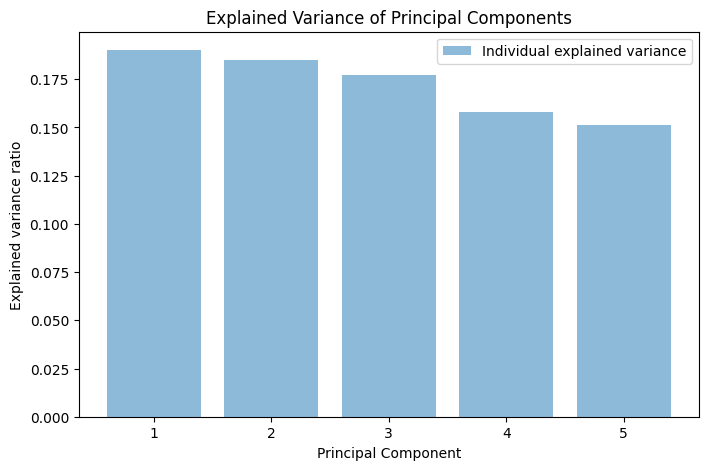

In [ ]:
import matplotlib.pyplot as plt

# Create dataframe with 5 PCs
df_pca = pd.DataFrame(
    data=X_pca,
    columns=[
        'Principal Component 1',
        'Principal Component 2',
        'Principal Component 3',
        'Principal Component 4',
        'Principal Component 5'
    ]
)

print('Original', X.shape)
print('PCA-transformed', df_pca.shape)
print(df_pca.head())

# Explained variance
explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance by each component:")
print(explained_variance)
print(f"Total variance explained by 5 components: {sum(explained_variance):.2%}")

# Visualize explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance of Principal Components')
plt.xticks(range(1, 6))
plt.legend(loc='best')
plt.show()


In [ ]:
# --- Isolation Forest for Anomaly Detection ---
from sklearn.ensemble import IsolationForest

# Train the model on PCA-transformed data
iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # % of data expected to be anomalies
    random_state=42
)

iso.fit(X_pca)

# Get anomaly scores
anomaly_scores = iso.decision_function(X_pca)

# Get predictions (-1 = anomaly, 1 = normal)
iso_labels = iso.predict(X_pca)

# Add results to a DataFrame
df_results = df.copy()
df_results["iso_score"] = anomaly_scores
df_results["iso_label"] = iso_labels  # -1 = anomaly, 1 = normal

print(df_results.head())


                             session_id        timestamp    user_id  \
0  fa7e2612-ae14-40de-98ca-136de4b0a8f1  6/23/2025 18:53  user_1654   
1  10a90222-2191-4697-a4a3-83010e6e5efa  6/24/2025 23:20  user_1114   
2  dd5673e2-732b-426c-abee-88235d582146  6/14/2025 14:09  user_1025   
3  1c15f3b8-5abb-4c25-b535-9c4061a4edbd   6/22/2025 2:24  user_1759   
4  04958d36-4a8b-4b5a-a5c4-6e50565d42b5   6/1/2025 16:34  user_1281   

       ip_address cloud_provider auth_method       session_type  \
0     95.54.96.67            AWS       Token  Interactive Login   
1  222.186.71.124          Azure    Password        CLI Command   
2  158.247.139.97            AWS       Token  Interactive Login   
3  85.151.124.106            GCP    Password  Interactive Login   
4  215.137.146.51            AWS       Token        CLI Command   

  resource_accessed  session_duration_sec  outcome anomaly_flag  iso_score  \
0  posts/wp-content                   359  Failure       Normal   0.126079   
1      tags/ex

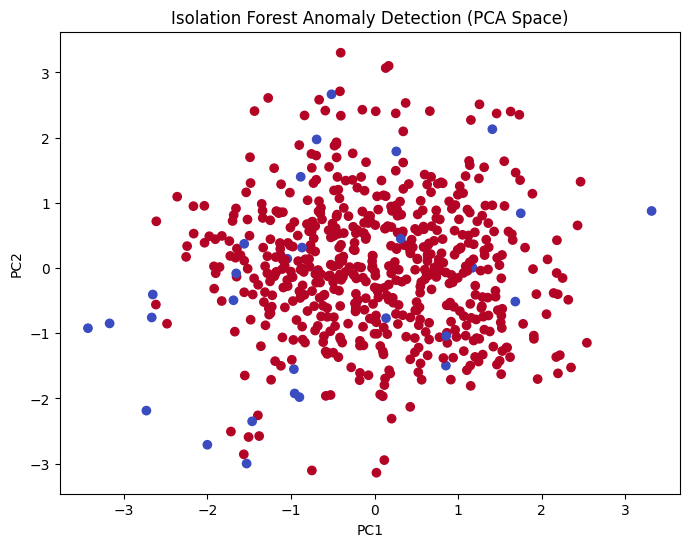

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(
    df_pca['Principal Component 1'],
    df_pca['Principal Component 2'],
    c=df_results["iso_label"],
    cmap='coolwarm'
)
plt.title("Isolation Forest Anomaly Detection (PCA Space)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


We want principal components that capture as much variance as possible because variance represents the meaningful patterns and differences in the data. Higher variance means that the PCA is preserving more of the important information, which improves the effectiveness of clustering, anomaly detection, and visualization. To increase the amount of variance captured, we can add meaningful features, remove noisy or irrelevant ones, encode categorical variables appropriately, and transform skewed features. In our case, the first five principal components capture 86% of the total variance, which is very good and indicates that most of the important information in our authentication session data is preserved for downstream analysis.

## Implementing Hierarchical Clustering

Now that PCA has reduced the dimensionality of the data and removed noise while preserving the most important patterns, we can move to our next step: implementing hierarchical clustering. This makes the data simpler and cleaner, allowing clustering algorithms to more effectively group similar sessions. By working on the principal components, hierarchical clustering can focus on the main sources of variation in the authentication session data, which improves the detection of patterns and potential anomalies.

Hierarchical clustering is preferred over K-means in this scenario for several reasons. First, it does not require specifying the number of clusters beforehand; the dendrogram produced by hierarchical clustering allows us to explore the natural structure of the data and decide where to cut for meaningful clusters. Second, hierarchical clustering can handle clusters of varying shapes and sizes, whereas K-means assumes roughly spherical clusters of similar size. Finally, it is particularly useful for anomaly detection because points that merge last or are far from other clusters in the dendrogram can be identified as potential anomalies. Combining PCA with hierarchical clustering provides a robust approach to uncover patterns and highlight unusual authentication sessions.

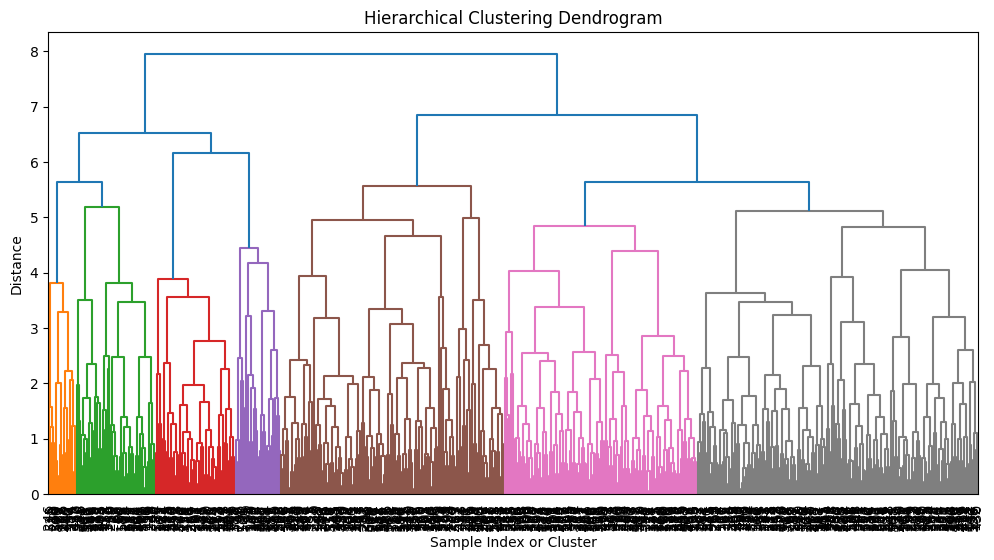

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the linkage matrix for hierarchical clustering
linked = linkage(X_pca, method='complete')  # 'ward' minimizes variance within clusters

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    truncate_mode='level',  # only show the last p merges
    p=20,                   # adjust to see more/less detail
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or Cluster')
plt.ylabel('Distance')
plt.show()

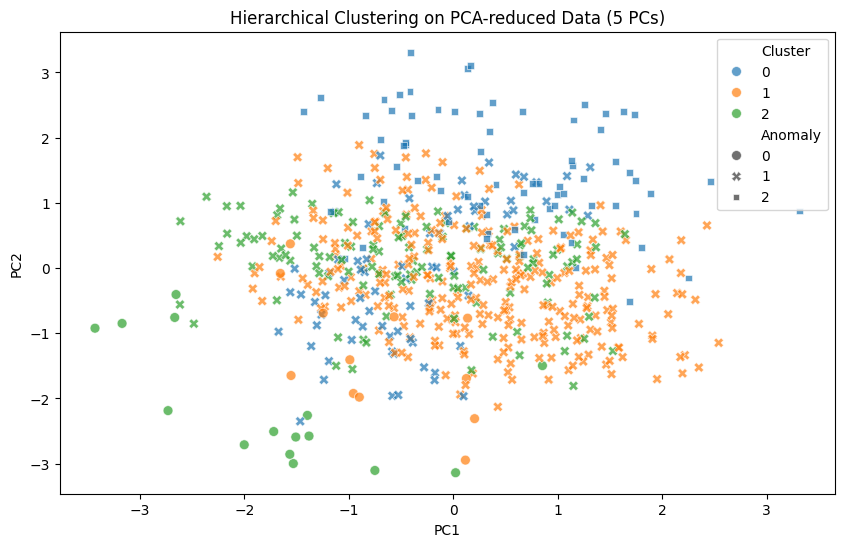

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Choose number of clusters based on dendrogram
n_clusters = 3
agg = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',  # updated from 'affinity'
    linkage='complete'
)
cluster_labels = agg.fit_predict(X_pca)

# Step 2: Add cluster labels to dataframe with 5 PCs
df_pca_clusters = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)
df_pca_clusters['Cluster'] = cluster_labels
df_pca_clusters['Anomaly'] = df_numeric['anomaly_flag']

# Step 3: Visualize clusters in 2D (using first 2 PCs)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    style='Anomaly',  # highlight known anomalies if available
    palette='tab10',
    data=df_pca_clusters,
    s=50,
    alpha=0.7
)
plt.title('Hierarchical Clustering on PCA-reduced Data (5 PCs)')
plt.show()


Let's explore the data that we now have:

In [ ]:
from scipy.cluster.hierarchy import fcluster, linkage

# Cut dendrogram at a chosen distance to assign clusters
distance_threshold = 10  # adjust based on dendrogram visualization
cluster_labels = fcluster(linked, t=distance_threshold, criterion='distance')
df_pca_clusters['Cluster'] = cluster_labels

# 3. Explore cluster characteristics
print("Cluster counts:")
print(df_pca_clusters['Cluster'].value_counts())

print("\nCluster feature means:")
print(df_pca_clusters.groupby('Cluster').mean())

# 5. Identify potential anomalies
# Small clusters or clusters with high anomaly ratio may indicate suspicious sessions
cluster_summary = df_pca_clusters.groupby('Cluster').agg(
    Count=('PC1', 'count'),
    Anomaly_Ratio=('Anomaly', 'mean')
).sort_values(by='Anomaly_Ratio', ascending=False)

print("\nPotential anomalous clusters:")
print(cluster_summary)

Cluster counts:
Cluster
1    600
Name: count, dtype: int64

Cluster feature means:
                  PC1           PC2           PC3           PC4           PC5  \
Cluster                                                                         
1        1.841120e-17  2.294461e-17  1.895475e-17 -4.200344e-17  1.572816e-17   

          Anomaly  
Cluster            
1        1.076667  

Potential anomalous clusters:
         Count  Anomaly_Ratio
Cluster                      
1          600       1.076667


In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_pca, df_pca_clusters['Cluster'])
print("Silhouette Score:", score)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

## Implement t-SNE

t-SNE is a technique that takes complicated, high-dimensional data and turns it into a simple 2D map. It places points that are similar close together and pushes points that are very different far apart, making natural groups and outliers easy to see. In our authentication log data, this helps reveal which sessions behave similarly—such as common login patterns, platforms, or user behavior—while highlighting unusual or isolated sessions that may indicate anomalies or suspicious activity.  

This process will make patterns, clusters, and outliers obvious. These things would normally be hidden in tables or raw feature columns, and might not be obvious to humans. In our authentication log data, this is especially valuable because it helps quickly identify groups of normal user behavior and visually highlight unusual or suspicious sessions that may require further investigation.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

The following t-SNE plot shows how similar authentication sessions group together based on their underlying behavior. Each point represents a single session, and points that appear close to each other share similar characteristics (such as platform, duration, outcome, or user patterns). Points that appear far apart represent sessions that behave very differently. Distinct clusters suggest common patterns among users or platforms, while isolated points or small separated clusters may indicate unusual or potentially anomalous activity.

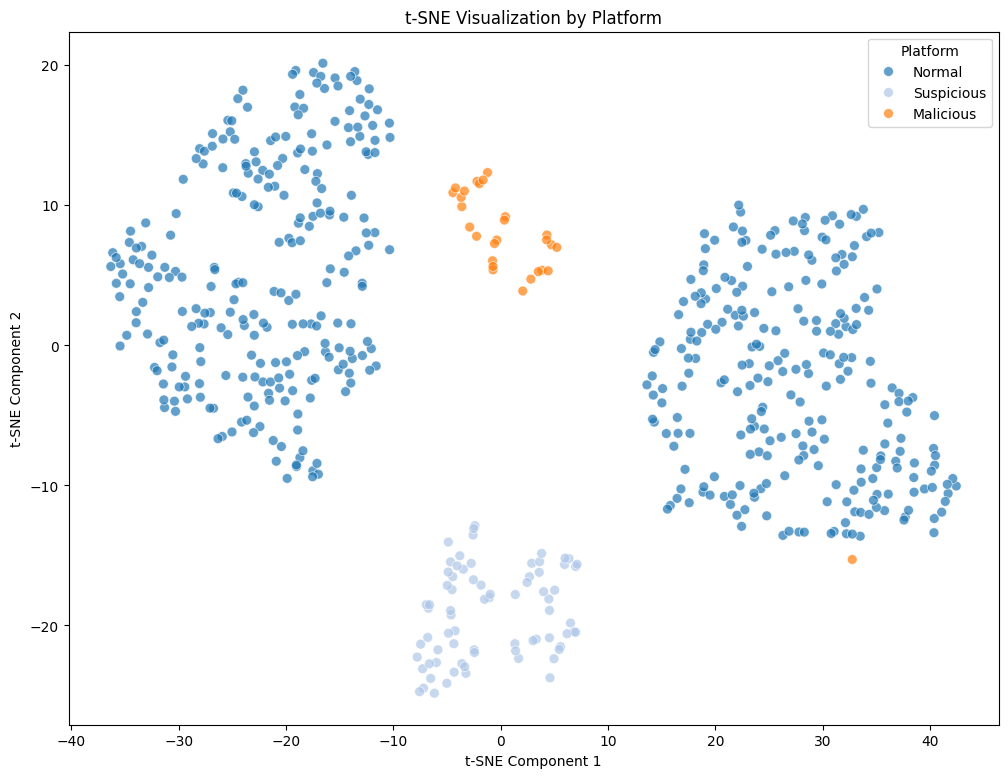

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert t-SNE array to DataFrame
tsne_df = pd.DataFrame({
    "t-SNE Component 1": X_tsne[:, 0],
    "t-SNE Component 2": X_tsne[:, 1],
    "Platform": df["anomaly_flag"]  # example column
})

plt.figure(figsize=(12, 9))
sns.scatterplot(
    data=tsne_df,
    x="t-SNE Component 1",
    y="t-SNE Component 2",
    hue="Platform",
    palette="tab20",
    s=50,
    alpha=0.7
)
plt.title("t-SNE Visualization by Platform")
plt.show()
